## The Effect of Vaccinations on Excess Mortality

The vaccinations offer an amazing protection against severe cases of COVID-19 and were able to widen the gap between infections and mortalities. We want to visualize this by computing the empirical mean and confidence intervals over 

In [1]:
# Make inline plots vector graphics
%matplotlib inline
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("pdf", "svg")

# Plotting setup
import matplotlib.pyplot as plt

# Package imports
import numpy as np
import pandas as pd
import scipy.stats
from tueplots import bundles

# Set Pyplot parameters to Neurips template
plt.rcParams.update(bundles.neurips2021(usetex=False))

We start by downloading the COVID data set from [OurWorldInData.org](https://github.com/owid/covid-19-data/tree/master/public/data).

In [2]:
# Link to world-wide data during the COVID pandemic
url = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"

# Read CSV data from URL
data_owid = pd.read_csv(url)

# Parse data
data_owid["date"] = pd.to_datetime(data_owid.date, format="%Y-%m-%d")

# Inspect dataframe and datatypes
display(data_owid.head())
data_owid.dtypes[0:5]

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


iso_code               object
continent              object
location               object
date           datetime64[ns]
total_cases           float64
dtype: object

Next, we extract the relevant columns, which are:
- excess_mortality: Percentage difference between the reported number of weekly or monthly deaths in 2020–2021 and the projected number of deaths for the same period based on previous years. 
- people_fully_vaccinated_per_hundred: Total number of people who received all doses prescribed by the vaccination protocol per 100 people in the total population

Since the excess mortality uses percentages, it is no major problem that we are mixing data reported weekly and monthly

In [3]:
# Remove columns, that are not needed
newcols = [
    "date",
    "iso_code",
    "excess_mortality",
    "people_fully_vaccinated_per_hundred"
]
data_owid.drop(columns=data_owid.columns.difference(newcols), inplace=True)

print("Shape prior to dropping NaN: ", data_owid.shape)
print("Number of countries: ", len(data_owid.iso_code.unique()))

# Remove entries with missing data
data_owid.dropna(inplace=True)
print("Shape after dropping NaN: ", data_owid.shape)
print("Number of countries: ", len(data_owid.iso_code.unique()))

# Sort along vaccination rate for easier sliding window applications
data_owid.sort_values(by=["people_fully_vaccinated_per_hundred"], inplace=True)

Shape prior to dropping NaN:  (159553, 4)
Number of countries:  238
Shape after dropping NaN:  (2060, 4)
Number of countries:  84


After extracting and inspecting the data, we transforms it into a two-dimensional numpy array.

In [43]:
# Split data
vaccinations = data_owid["people_fully_vaccinated_per_hundred"].to_numpy()
excess_mortality = data_owid["excess_mortality"].to_numpy()

Next, we define a function to compute the empirical mean and confidence intervals for a given set of data. The confidence interval is computed using the Student's t-distribution, because assume the data is Gaussian.

In [88]:
def mean_confidence_interval(data, confidence=0.95):
    """
    Computes the 
    
    Params:
    data: array
        Contains data that is presumed to be approximately Gaussian distributed.
    confidence: float, default = 0.95
        The confidence level to be used for the confidence interval.
    """
    n = len(data)
    mean, standard_error = np.mean(data), scipy.stats.sem(data)
    conf_band = standard_error * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    
    return mean, mean + conf_band, mean - conf_band

In [91]:
window_size = 50
# pad by edge values
excess_mortality_pad = np.pad(excess_mortality, (window_size, window_size), 'reflect')

output_l = []
for i in range(len(vaccinations)):
    vacc_rate = vaccinations[i]
    window = excess_mortality_pad[i:i+2*window_size+1]
    mean, lower, upper = mean_confidence_interval(window, confidence=0.99999)
    output_l.append((vacc_rate, mean, lower, upper))
    
output = np.array(output_l)

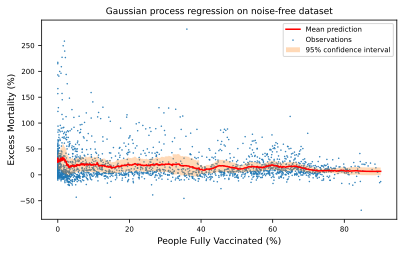

In [92]:
# Extract statistics
vaccine_rate = output[:, 0]
ex_mort_mean = output[:, 1]
ex_mort_lower = output[:, 2]
ex_mort_upper = output[:, 3]

# Plot
plt.scatter(data[:, 0], data[:, 1], label="Observations", s=0.3)
plt.plot(vaccine_rate, ex_mort_mean, label="Mean prediction", c="r")
plt.fill_between(
    vaccine_rate,
    ex_mort_lower,
    ex_mort_upper,
    alpha=0.3,
    label=r"95% confidence interval",
)

plt.legend()
plt.xlabel("People Fully Vaccinated (%)")
plt.ylabel("Excess Mortality (%)")
_ = plt.title("Gaussian process regression on noise-free dataset")

Of course the confidence interval is nonsense, because I'm not interested in the confidence of an estimator of the mean, but the distribution itself. However, the Student's t-distribution ist only needed for the former and not useful for the latter.